In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

EPSILON = 1e-5

In [22]:
model = VGG16(weights='imagenet', include_top=False)

LAYER_NAME = 'block3_conv1'
FILTER_INDEX = 0
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [23]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + EPSILON)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [24]:
def generate_pattern(layer_name, filter_index, size=150, steps=40):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # usually 2nd parameter would be model weights
    
    grads = K.gradients(loss, model.input)[0] # unlist
    grads /= (K.sqrt(K.mean(K.square(grads))) + EPSILON)

    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

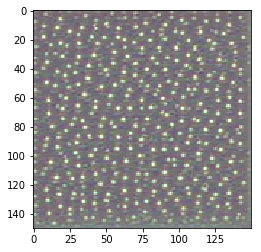

In [25]:
plt.imshow(generate_pattern(LAYER_NAME, FILTER_INDEX))

In [26]:
x = np.array([[9, 8, 3], [40, 39, 0], [75, 74, 73]], np.float)
x

array([[ 9.,  8.,  3.],
       [40., 39.,  0.],
       [75., 74., 73.]])

In [27]:
deprocess_image(x)

array([[105, 104,  99],
       [131, 130,  97],
       [160, 159, 158]], dtype=uint8)

In [28]:
help(K.gradients)

Help on function gradients in module tensorflow.python.keras.backend:

gradients(loss, variables)
    Returns the gradients of `loss` w.r.t. `variables`.
    
    Arguments:
        loss: Scalar tensor to minimize.
        variables: List of variables.
    
    Returns:
        A gradients tensor.



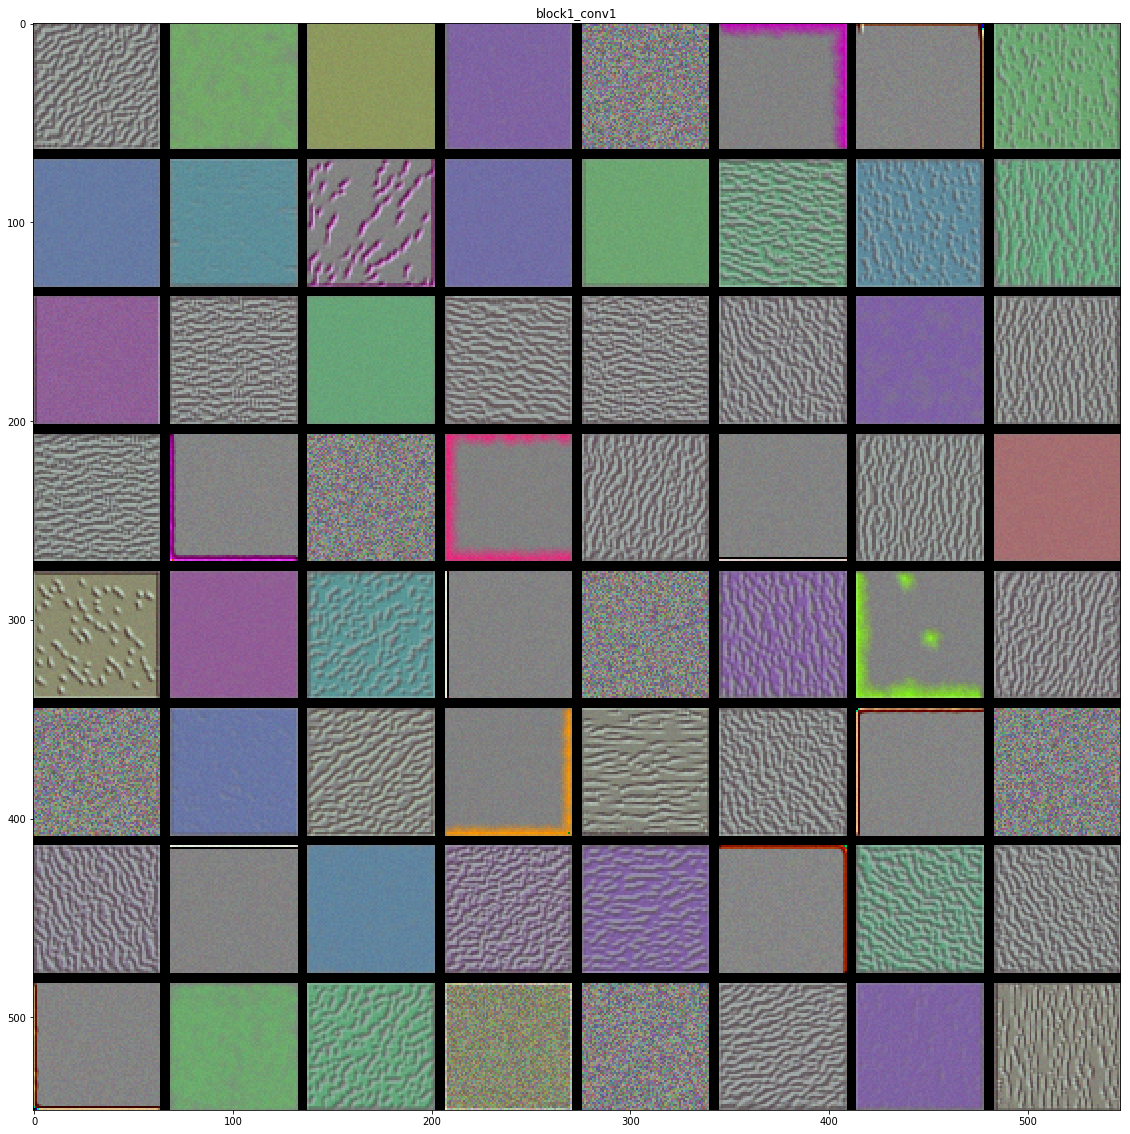

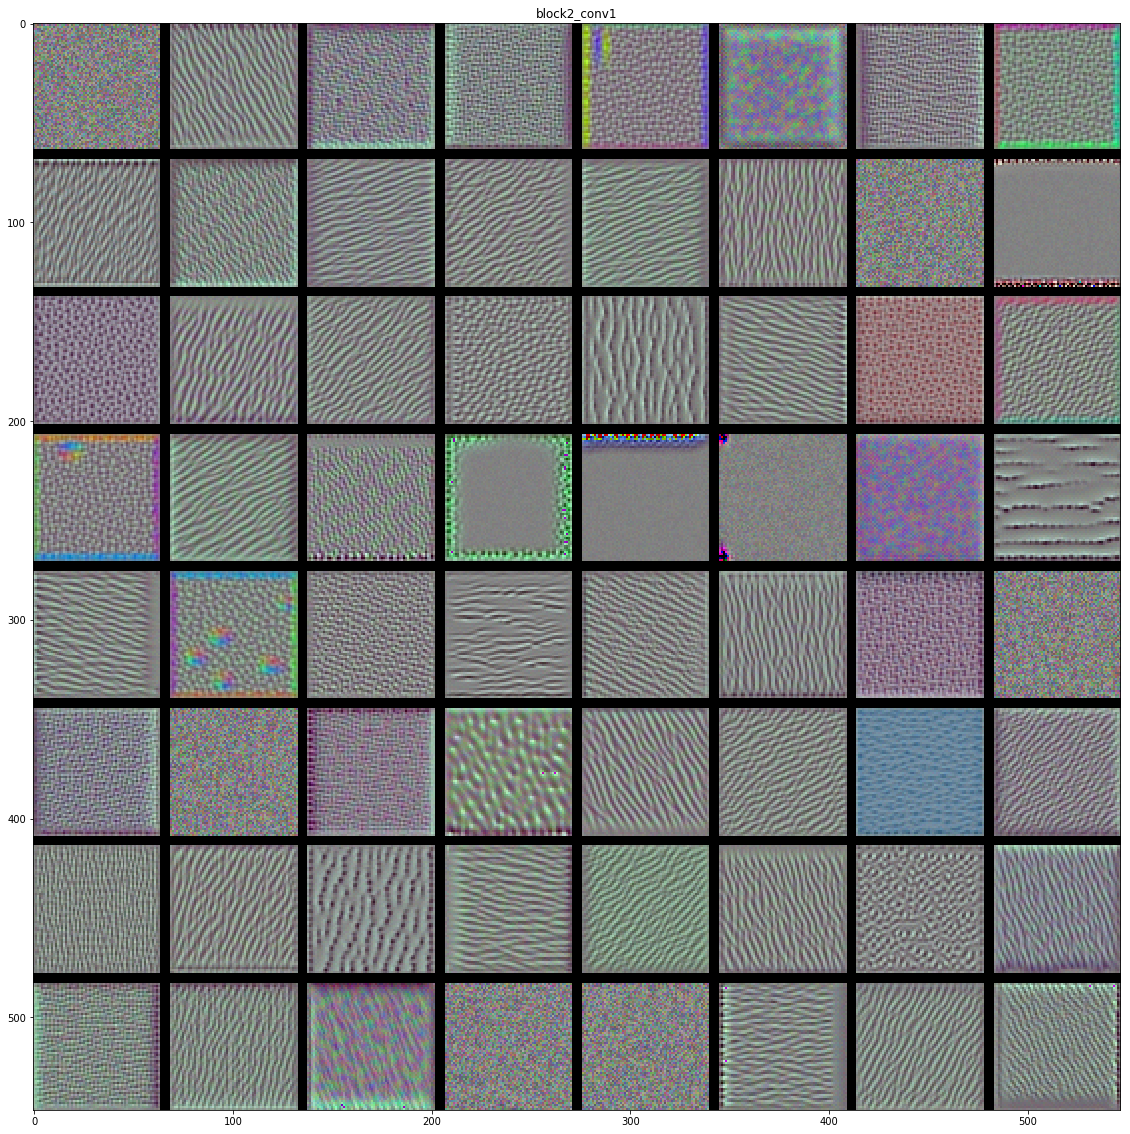

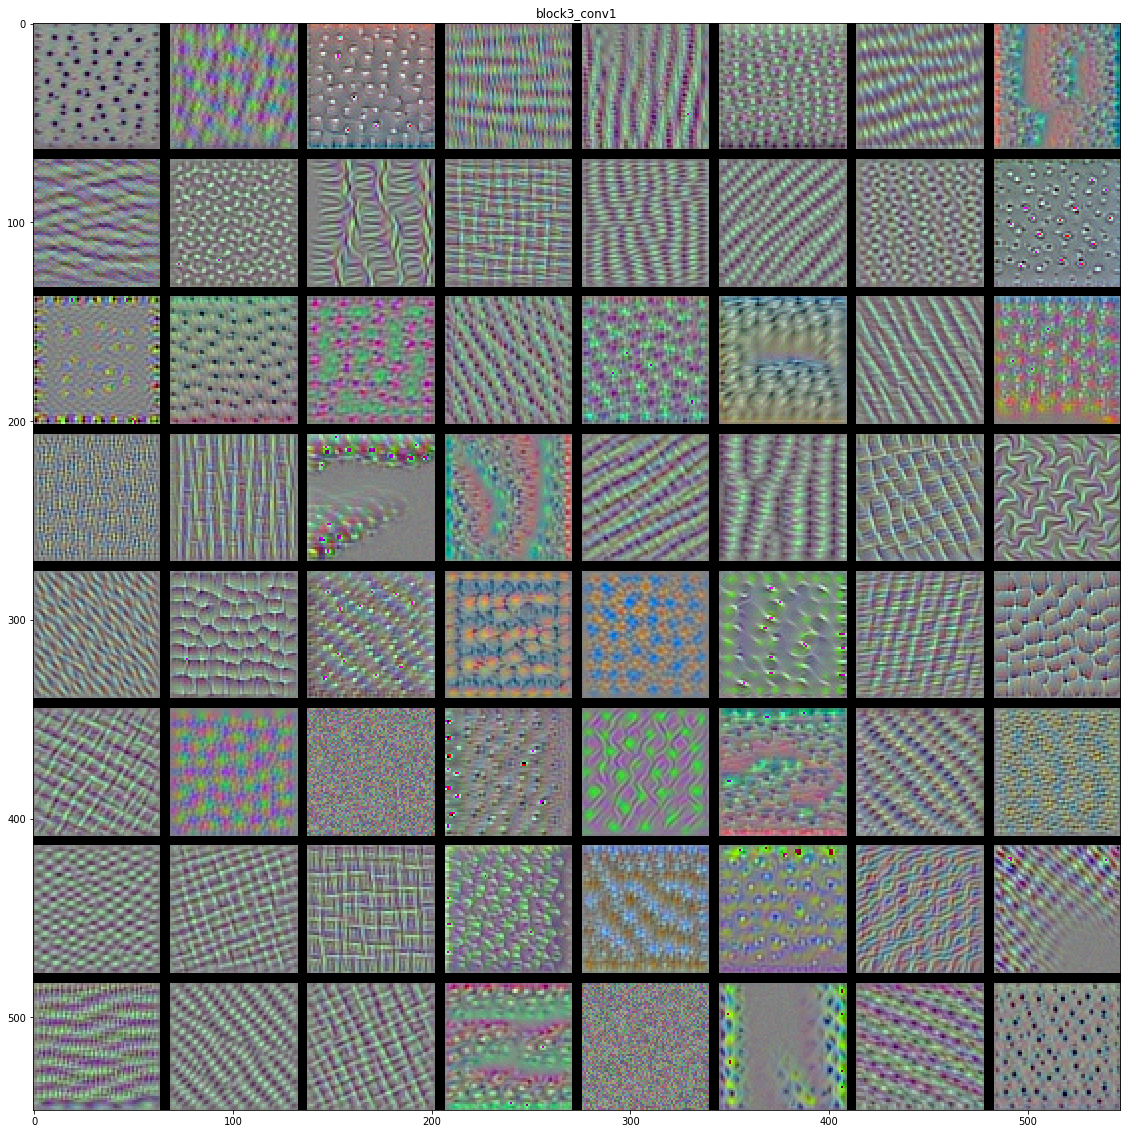

In [32]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1']

size = 64
margin = 5
rows = 8
cols = 8
gaps = rows - 1

results = np.zeros((rows * size + gaps * margin, cols * size + gaps * margin, 3))

for layer_name in layer_names:
    for i in range(cols):
        for j in range(rows):
            filter_id = i + (j * 8)
            filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
            
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start : horizontal_end,
                   vertical_start : vertical_end, :] = filter_img
            
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.title(layer_name)
